### Data Filtering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img
from PIL import Image

df = pd.read_csv('../datasets/clustering_data.csv')
df.replace('NA', pd.NA, inplace=True)
df.drop_duplicates(keep='first')

state_data = df[df['StateName'] == 'DELHI'].dropna()

C:\Users\Aroshish\AppData\Local\Temp\ipykernel_20500\1952424846.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../datasets/clustering_data.csv')


### Data Visualization

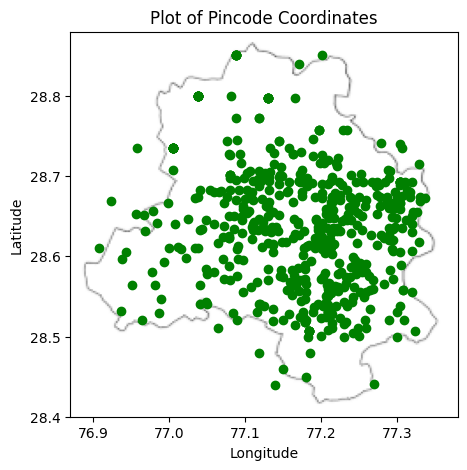

In [17]:
latitudes = state_data['Latitude'].astype(float)
longitudes = state_data['Longitude'].astype(float)

def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

latitudes = remove_outliers(latitudes)
longitudes = remove_outliers(longitudes)

# print(len(latitudes))
# print(len(longitudes))

image = Image.open('delhi_outline.png')
fig, ax = plt.subplots(figsize = (5, 5))

ax.imshow(image, extent=[76.87, 77.38, 28.40, 28.88], aspect='auto')
ax.scatter(longitudes, latitudes[:len(longitudes)], c='green')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Plot of Pincode Coordinates")

# plt.scatter(longitudes, latitudes[:len(longitudes)], c='b')
plt.show()

### Clustering Analysis

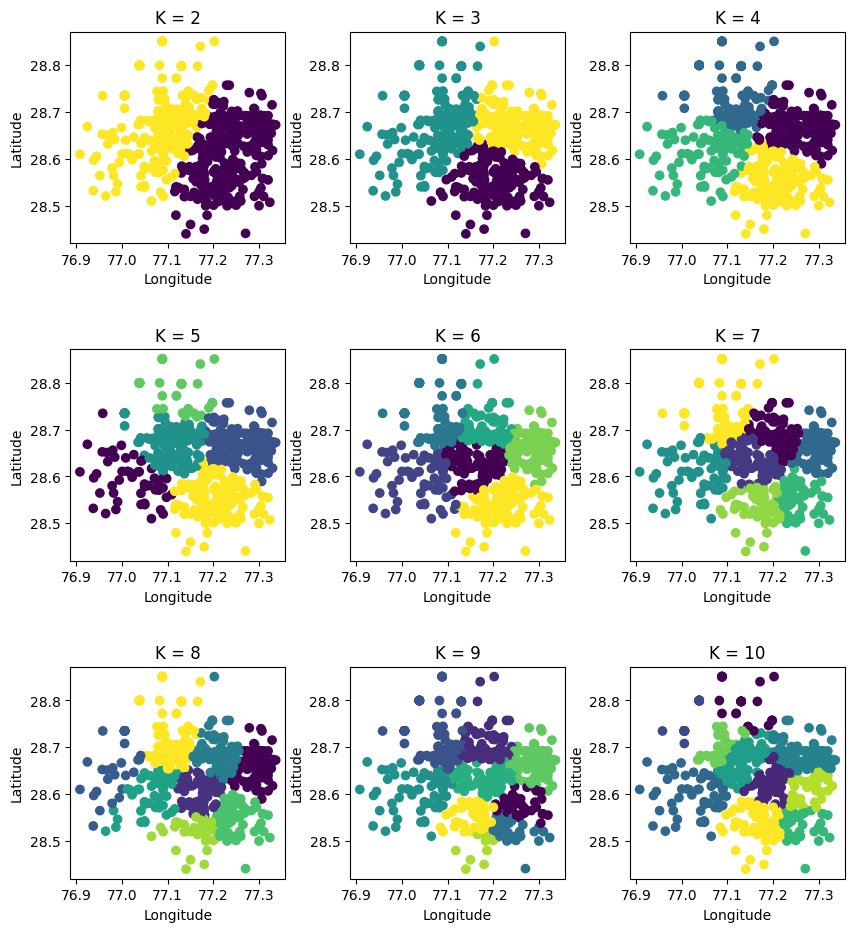

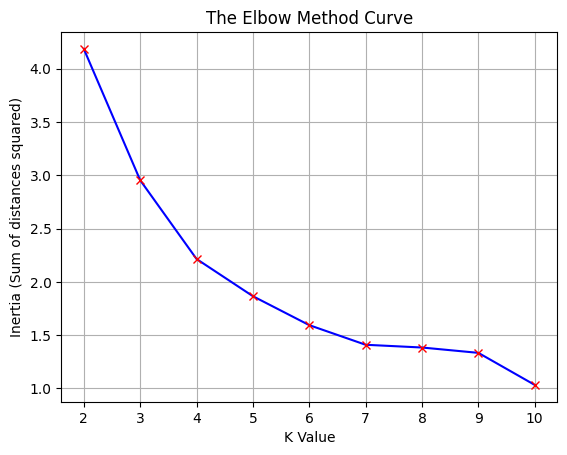

In [18]:
latitudes = latitudes[:len(longitudes)]
latitudes = latitudes.reset_index(drop = True)
longitudes = longitudes.reset_index(drop = True)

data_pts = len(longitudes)

fig, ax = plt.subplots(3, 3, figsize = (10, 11))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

inertia_values = np.zeros(11)
np.random.seed(10)

for K in np.arange(2, 11):
    initial_cluster_pts = np.random.choice(np.arange(data_pts), K, replace=False)

    def distance(cluster_pt, data_pt):
        distance = 0
        for i in np.arange(len(cluster_pt)):
            distance += (cluster_pt[i] - data_pt[i]) ** 2

        return np.sqrt(distance)

    coordinates = np.array([[longitudes[pt], latitudes[pt]] for pt in np.arange(data_pts)])
    cluster_pts = np.array([[longitudes[pt], latitudes[pt]] for pt in initial_cluster_pts])

    clustered_data = np.zeros(data_pts)

    for k in np.arange(100):
        for point_index, point in enumerate(coordinates):
            distances = np.zeros(K_sel)
            for i in np.arange(K):
                distances[i] = distance(cluster_pts[i], point)
            
            clustered_data[point_index] = np.argmin(distances)

        #Update cluster points
        new_cluster_pts = cluster_pts.copy()
        for i in np.arange(K):
            current_cluster = coordinates[np.where(clustered_data == i)]
            if len(current_cluster > 0):
                new_cluster_pts[i] = current_cluster.mean(axis=0)
        
        if not np.all(np.abs(new_cluster_pts - cluster_pts)):
            inertia = 0
            for point_index, point in enumerate(coordinates):
                its_cluster_point = cluster_pts[int(clustered_data[point_index])]
                inertia += distance(its_cluster_point, point) ** 2

            inertia_values[K] = inertia
            break

        cluster_pts = new_cluster_pts

    plt.subplot(3, 3, K - 1)
    plt.title(f"K = {K}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.scatter(longitudes, latitudes, c=clustered_data)

plt.show()

K_values = np.arange(2, 11)
plt.plot(K_values, inertia_values[2:], color = 'blue', marker = 'x', mec = 'red')
plt.grid(True)
plt.xlabel("K Value")
plt.ylabel("Inertia (Sum of distances squared)")
plt.title("The Elbow Method Curve")
plt.savefig("elbow_curve.png")
plt.show()

From the elbow curve, the most suitable value of K seems to be 4.

### Plot with K = 4

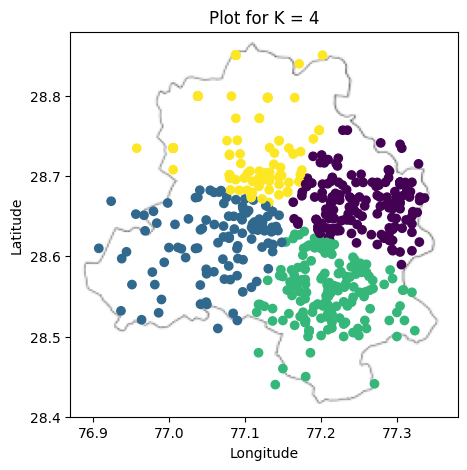

In [31]:
K_sel = 4

np.random.seed(42)

initial_cluster_pts = np.random.choice(np.arange(data_pts), K_sel, replace=False)

coordinates = np.array([[longitudes[pt], latitudes[pt]] for pt in np.arange(data_pts)])
cluster_pts = np.array([[longitudes[pt], latitudes[pt]] for pt in initial_cluster_pts])

clustered_data = np.zeros(data_pts)

for k in np.arange(100):
    for point_index, point in enumerate(coordinates):
        distances = np.zeros(K_sel)
        for i in np.arange(K_sel):
            distances[i] = distance(cluster_pts[i], point)
        
        clustered_data[point_index] = np.argmin(distances)

    #Update cluster points
    new_cluster_pts = cluster_pts.copy()
    for i in np.arange(K_sel):
        current_cluster = coordinates[np.where(clustered_data == i)]
        if len(current_cluster > 0):
            new_cluster_pts[i] = current_cluster.mean(axis=0)
    
    if not np.all(np.abs(new_cluster_pts - cluster_pts)):
        break

    cluster_pts = new_cluster_pts

image = Image.open('delhi_outline.png')
fig, ax = plt.subplots(figsize = (5, 5))

ax.imshow(image, extent=[76.87, 77.38, 28.40, 28.88], aspect='auto')
ax.scatter(longitudes, latitudes, c=clustered_data)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Plot for K = {K_sel}")
plt.show()

### Inferences and Insights

##### Environmental Factors
* The eastern pincodes (purple) are more densely placed compared to the weatern ones, which could be because the Yamuna River flows through those regions, indicating higher historical settlements.

* The lowest portion of the green cluster is sparsely populated. This may be due to higher elevation of southern Delhi compared to other parts.

##### Roads and Infrastructure

* The blue region is bounded by NH 9 and NH 48, indicating they may have been divided by authorities that way.
* The green region is bounded by  NH 48 and Delhi-Noida Flyway.
* The purple region is separated from others by the Mahatma Gandhi Road

##### Socio-Economic Factors

* The left part of the purple portion is densely populated with pin codes as it comprises of Lutyens' Delhi, a posh area, with higher income levels, property values and commercial activity.

* The central region is New Delhi, the capital. This may indicate why the distribution is denser towards the middle.

* The northern region has fewer pin codes which may be a result of lower population due to higher crime rates. (Source: https://timesofindia.indiatimes.com/city/delhi/40pc-of-citys-heinous-crimes-in-ne-district/articleshow/55590439.cms)
